# Predicting Minecraft Newsletter Subscription Using Player Demographics and Gameplay Behaviour Using K-NN

DSCI 100-008 Group 30

Authors: Gavin Gao, Bryn Gill, Helen Zao, Tim Wang

Date submitted: Dec 6th, 2025

# 1. Introduction

### 1.1 Background


Video games aren’t just for entertainment, they also provide valuable information about human behavior! Dr. Frank Wood and his research group in Computer Science at UBC has collected data about player information through a minecraft server, including characteristics such as age, gender, total game play. Managing and maintaining the server won’t be an easy task, so they are seeking answers to some questions such as what kinds of players join, and who is likely to engage more deeply with the project. In particular, we will be focusing on answering the question: Can a player's experience, hours played, age and gender predict whether a player would subscribe to a game-related newsletter?


### 1.2 Basic Dataset Description
* Response variable: **subscribe** is chosen since its a TRUE/FALSE, categorical variable, it is available for prediction using classification algorithms
* Explanatory variables:
    * **experience** (factor: Pro, Veteran, etc.)
    * **played_hours** (numeric)
    * **Age** (numeric)
    * **gender** (categorical)
* How data will help answer question:
    * players.csv directly provides all predictors.
    * No merging is needed, unless more specific description is wanted e.g., number of sessions
    * subscribe is cleanly provided as a catagorical variable with only 2 classes
* Wrangling needed:
    * Convert categorical variables (experience, gender) to factors
    * Remove missing values (NA) in all predictors
    * Possibly normalize played_hours
    * Result in a tidy tibble by removing redundent or duplicate columns (hashedEmail) or selecting only columns of intrest
* Predictive method:
    * Works with k-NN classification

### 1.2.1 File Reading and Preview


In [1]:
#Needed Libraries:
library(tidyverse) 
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Read the data remotely 
url_players <- "https://raw.githubusercontent.com/Tim-W36/DSCI-100-Group-30-Final-Project-Report-/main/players.csv"
url_sessions <- "https://raw.githubusercontent.com/Tim-W36/DSCI-100-Group-30-Final-Project-Report-/main/sessions.csv"
players <- read_csv(url_players)
sessions <- read_csv(url_sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Preview datasets
head(players)
head(sessions)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### 1.2.2 Overview: Number of Observations and Variables

In [4]:
dataset_overview <- tibble(
  dataset        = c("players", "sessions"),
  n_observations = c(nrow(players), nrow(sessions)),
  n_variables    = c(ncol(players), ncol(sessions))
)

dataset_overview

dataset,n_observations,n_variables
<chr>,<int>,<int>
players,196,7
sessions,1535,5


### 1.2.3 Variable Summaries (players.csv, sessions.csv)

In [5]:
players_var_summary <- tibble(
  variable = c("experience", "subscribe", "hashedEmail",
               "played_hours", "name", "gender", "Age"),
  
  type = c("categorical", "categorical", "character",
           "numeric", "character", "categorical", "numeric"),
  
  description = c(
    "Self reported experience level",
    "YES or NO for subscribed to the game-related newsletter",
    "Hashed email identifier used to link to sessions.csv",
    "Total hours the player has spent on the server",
    "Player's in-game name (may not be unique)",
    "Player gender",
    "Player age in years"
  )
)

players_var_summary

sessions_var_summary <- tibble(
  variable = c("hashedEmail", "start_time", "end_time",
               "original_start_time", "original_end_time"),
  
  type = c("character", "character", "character",
           "numeric", "numeric"),
  
  description = c(
    "Hashed email identifier used to link to players.csv",
    "Session start time as readable string (dd/mm/yyyy HH:MM)",
    "Session end time as readable string",
    "Session start time as system clock value",
    "Session end time as system clock value"
  )
)

sessions_var_summary


variable,type,description
<chr>,<chr>,<chr>
experience,categorical,Self reported experience level
subscribe,categorical,YES or NO for subscribed to the game-related newsletter
hashedEmail,character,Hashed email identifier used to link to sessions.csv
played_hours,numeric,Total hours the player has spent on the server
name,character,Player's in-game name (may not be unique)
gender,categorical,Player gender
Age,numeric,Player age in years


variable,type,description
<chr>,<chr>,<chr>
hashedEmail,character,Hashed email identifier used to link to players.csv
start_time,character,Session start time as readable string (dd/mm/yyyy HH:MM)
end_time,character,Session end time as readable string
original_start_time,numeric,Session start time as system clock value
original_end_time,numeric,Session end time as system clock value


### 1.2.4 Numeric Summary Statistics (2 decimals)

In [6]:
players_numeric_summary <- players |>
  summarise(
    played_hours_mean = round(mean(played_hours, na.rm = TRUE), 2),
    played_hours_sd   = round(sd(played_hours, na.rm = TRUE), 2),
    played_hours_min  = round(min(played_hours, na.rm = TRUE), 2),
    played_hours_max  = round(max(played_hours, na.rm = TRUE), 2),
    Age_mean          = round(mean(Age, na.rm = TRUE), 2),
    Age_sd            = round(sd(Age, na.rm = TRUE), 2),
    Age_min           = round(min(Age, na.rm = TRUE), 2),
    Age_max           = round(max(Age, na.rm = TRUE), 2)
  )

players_numeric_summary

sessions_numeric_summary <- sessions |>
  summarise(
    original_start_time_mean = round(mean(original_start_time, na.rm = TRUE), 2),
    original_start_time_sd   = round(sd(original_start_time, na.rm = TRUE), 2),
    original_start_time_min  = round(min(original_start_time, na.rm = TRUE), 2),
    original_start_time_max  = round(max(original_start_time, na.rm = TRUE), 2),
    original_end_time_mean   = round(mean(original_end_time, na.rm = TRUE), 2),
    original_end_time_sd     = round(sd(original_end_time, na.rm = TRUE), 2),
    original_end_time_min    = round(min(original_end_time, na.rm = TRUE), 2),
    original_end_time_max    = round(max(original_end_time, na.rm = TRUE), 2)
  )

sessions_numeric_summary

played_hours_mean,played_hours_sd,played_hours_min,played_hours_max,Age_mean,Age_sd,Age_min,Age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.85,28.36,0,223.1,21.14,7.39,9,58


original_start_time_mean,original_start_time_sd,original_start_time_min,original_start_time_max,original_end_time_mean,original_end_time_sd,original_end_time_min,original_end_time_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.719201e+12,3557491589,1.7124e+12,1.72733e+12,1.719196e+12,3552813134,1.7124e+12,1.72734e+12


### 1.2.5 Categorical summaries

In [7]:
# players: experience
players_experience_counts <- players |>
  count(experience)

players_experience_counts

# players: subscribe
players_subscribe_counts <- players |>
  count(subscribe)

players_subscribe_counts

# players: gender
players_gender_counts <- players |>
  count(gender)

players_gender_counts

experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,144


gender,n
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


### 1.2.6 Missing values

In [8]:
players_missing <- tibble(
  variable   = c("experience", "subscribe", "hashedEmail",
                 "played_hours", "name", "gender", "Age"),
  n_missing  = c(
    sum(is.na(players$experience)),
    sum(is.na(players$subscribe)),
    sum(is.na(players$hashedEmail)),
    sum(is.na(players$played_hours)),
    sum(is.na(players$name)),
    sum(is.na(players$gender)),
    sum(is.na(players$Age))
  )
)

players_missing

sessions_missing <- tibble(
  variable  = c("hashedEmail", "start_time", "end_time",
                "original_start_time", "original_end_time"),
  n_missing = c(
    sum(is.na(sessions$hashedEmail)),
    sum(is.na(sessions$start_time)),
    sum(is.na(sessions$end_time)),
    sum(is.na(sessions$original_start_time)),
    sum(is.na(sessions$original_end_time))
  )
)

sessions_missing

variable,n_missing
<chr>,<int>
experience,0
subscribe,0
hashedEmail,0
played_hours,0
name,0
gender,0
Age,2


variable,n_missing
<chr>,<int>
hashedEmail,0
start_time,0
end_time,2
original_start_time,0
original_end_time,2


### 1.2.7 Data Quality

#### Uniqueness of hashedEmail in players

In [9]:
players_hashedEmail_uniqueness <- players |>
  summarise(
    n_players          = n(),
    n_unique_hashed_id = length(unique(hashedEmail))
  )

players_hashedEmail_uniqueness

n_players,n_unique_hashed_id
<int>,<int>
196,196


#### Number of players have at least one session

In [10]:
players_with_sessions <- sessions |>
  select(hashedEmail) |>
  distinct() |>
  inner_join(players, by = "hashedEmail") |>
  summarise(n_players_with_sessions = n())

players_with_sessions

n_players_with_sessions
<int>
125


# 1.3 Detailed Dataset Description and Visual

In [11]:
# Make Data Tidy 
players_tidy <- players |>
  mutate(
    subscribe = as_factor(subscribe),
    experience = as_factor(experience),
    gender = as_factor(gender),
    hashedEmail = as.character(hashedEmail)) |> 
    select(subscribe, experience, played_hours, Age, gender) |> drop_na() #variables of intrest are retained and rows with NA observations dropped
slice(players_tidy, 1:8) #for preview

sessions_tidy <- sessions |>
  mutate(
    start_time = as_datetime(start_time, format = "%d/%m/%Y %H:%M"),
    end_time   = as_datetime(end_time,   format = "%d/%m/%Y %H:%M"),
    hashedEmail = as.character(hashedEmail)
  )
slice(sessions_tidy, 1:8)

subscribe,experience,played_hours,Age,gender
<fct>,<fct>,<dbl>,<dbl>,<fct>
TRUE,Pro,30.3,9,Male
TRUE,Veteran,3.8,17,Male
FALSE,Veteran,0.0,17,Male
TRUE,Amateur,0.7,21,Female
TRUE,Regular,0.1,21,Male
TRUE,Amateur,0.0,17,Female
TRUE,Regular,0.0,19,Female
FALSE,Amateur,0.0,21,Male


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-04-15 07:12:00,2024-04-15 07:21:00,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,2024-09-21 02:13:00,2024-09-21 02:30:00,1.72688e+12,1.72689e+12


### 1.3.1 Mean value for each quantitative variable in players.csv 

In [12]:
players_means <- players_tidy |>
  summarise(
    mean_played_hours = mean(played_hours, na.rm = TRUE),
    mean_age = mean(Age, na.rm = TRUE)
  )

players_means

mean_played_hours,mean_age
<dbl>,<dbl>
5.904639,21.13918


#### 1.3.2 Distribution of Player Ages

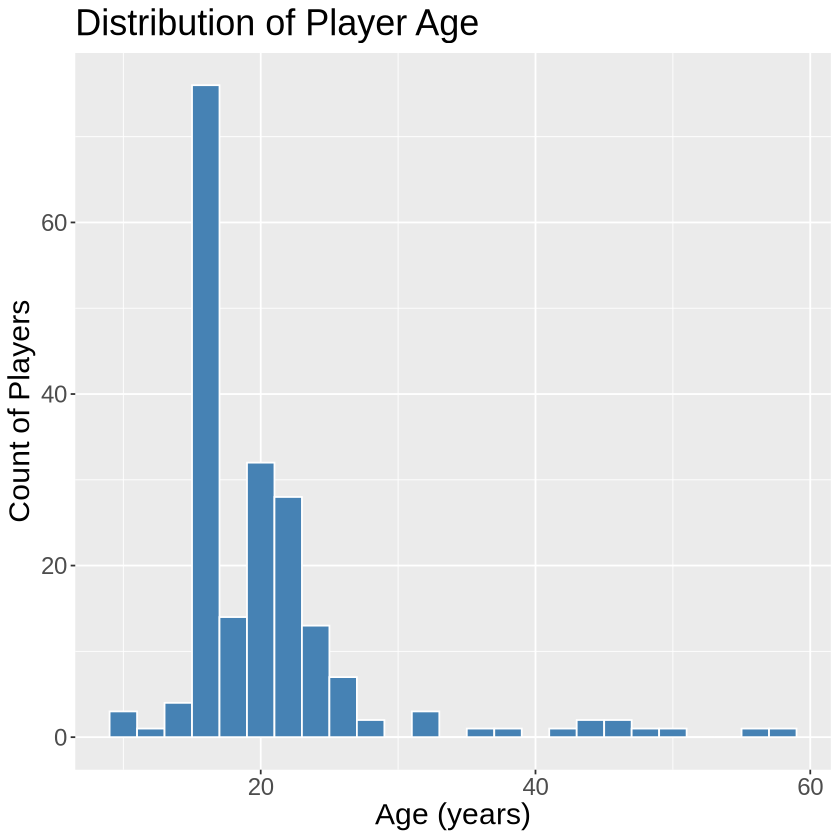

In [13]:
theme_update(text = element_text(size = 18))
ggplot(players_tidy, aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "steelblue", color = "white") +
  labs(
    title = "Distribution of Player Age",
    x = "Age (years)",
    y = "Count of Players"
  )


Figure 1: 
The histogram above clearly illustrates that the majority of players are around 10 to 28 years old, with the highest 
number of players at age 16 with the highest peak on the graph. Additionally, as player age increases the number of 
players decrease as illustrated by the least amount of players in the 60 age range. This graph helps us possibly determine that players in the age range of 10 to 28 may be more likely to subscribe to a game-related newsletter, since they spend the most time playing on the Minecraft server, whereas the older ages from about 30-60 don't play as much Minecraft, indicating they are less likely to subscribe to a game-related newsletter. 

#### 1.3.3 Played Hours Distribution

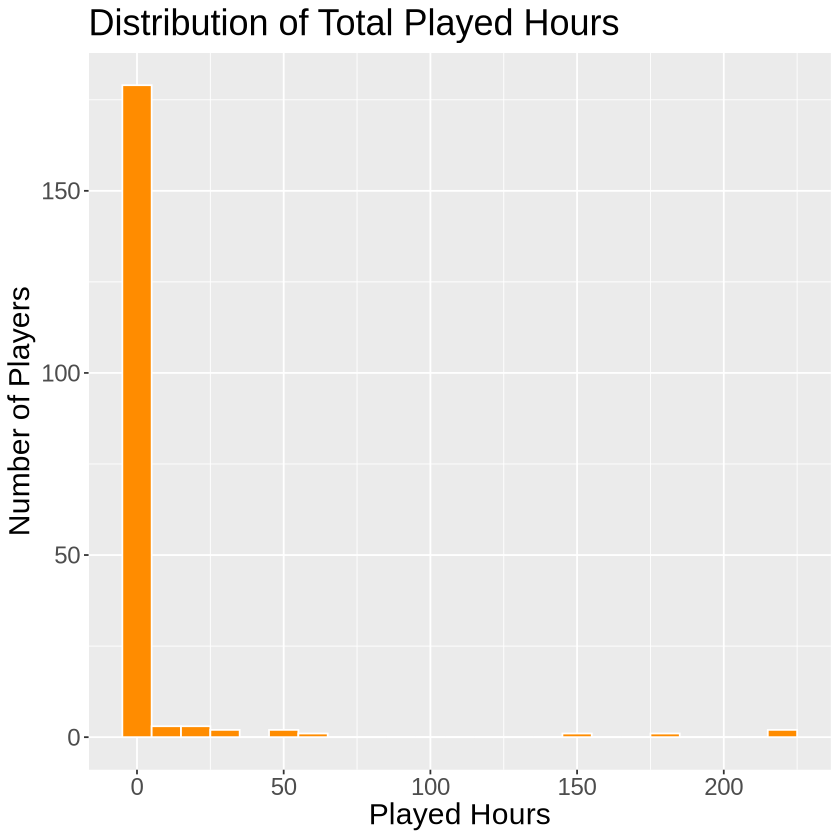

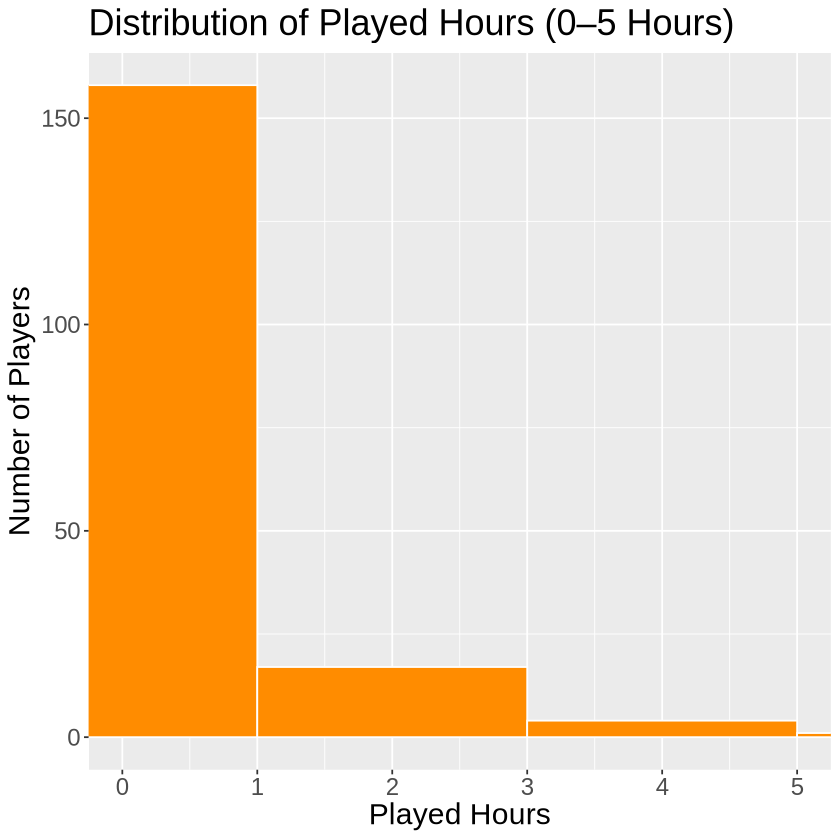

In [14]:
ggplot(players_tidy, aes(x = played_hours)) +
  geom_histogram(binwidth = 10, fill = "darkorange", color = "white") +
  labs(
    title = "Distribution of Total Played Hours",
    x = "Played Hours",
    y = "Number of Players"
  )

ggplot(players_tidy, aes(x = played_hours)) +
  geom_histogram(binwidth = 2, fill = "darkorange", color = "white") +
  coord_cartesian(xlim = c(0, 5)) +
  labs(
    title = "Distribution of Played Hours (0–5 Hours)",
    x = "Played Hours",
    y = "Number of Players"
  )


Figure 2: 
Both histograms above demonstrate that the majority of players only logged onto the Minecraft server for about 1-3hrs. The highest amount of players logged on for approximately 1 hour, as illustrated by the highest peak on the graphs. There are some extreme outliers where players were logged on for 150-215hrs. This data can help us determine that since the majority of players only log on for such a short period of time, they may not be engaged enough to subsrcibe to a game-related newsletter, however some of the players who log on for 3-5 hours may be more inclined to subscribe, since they appear to be more engaged/spend more time on the server. So, it appears as though only a small majority of players may subscribe to the newsletter. 

#### 1.3.4 Played Hours vs Age

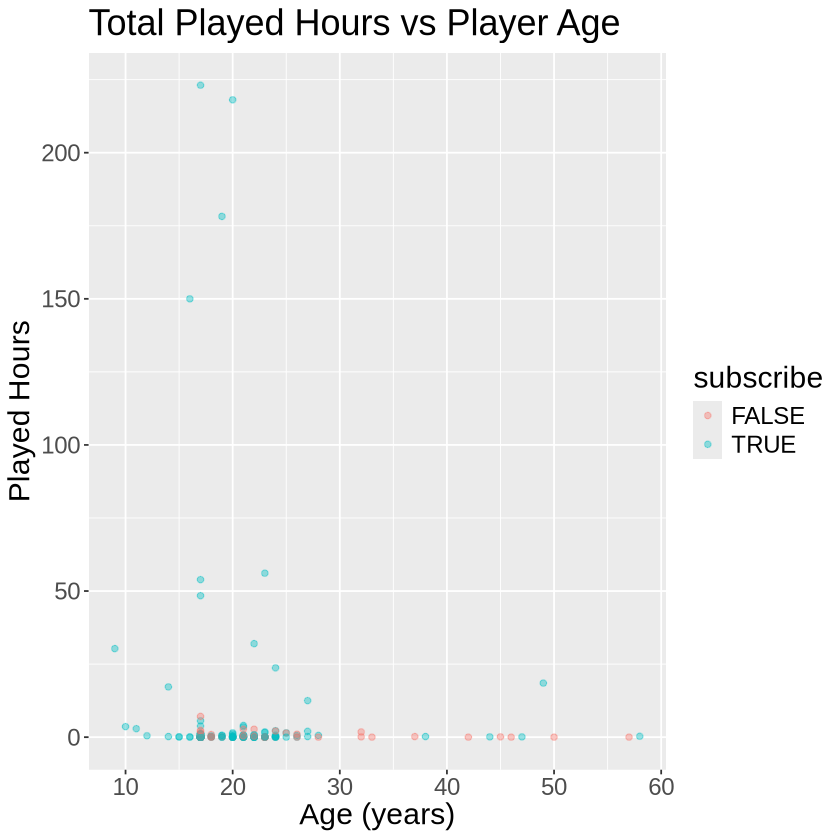

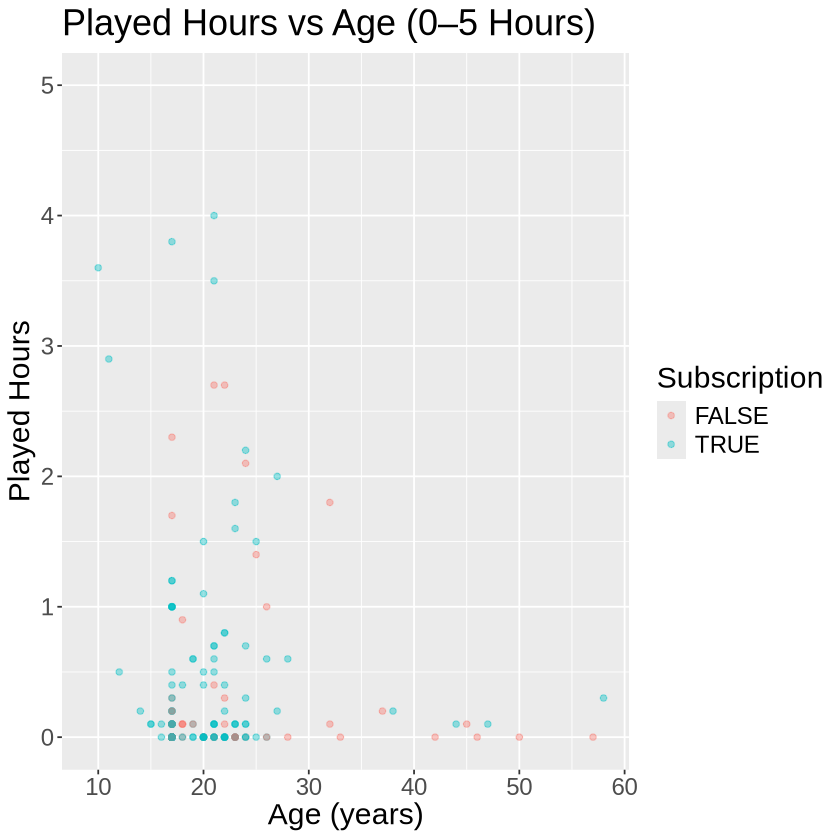

In [15]:
ggplot(players_tidy, aes(x = Age, y = played_hours, colour = subscribe)) +
  geom_point(alpha = 0.4) +
  labs(
    title = "Total Played Hours vs Player Age",
    x = "Age (years)",
    y = "Played Hours"
  )

ggplot(players_tidy, aes(x = Age, y = played_hours, colour = subscribe)) +
  geom_point(alpha = 0.4) +
  coord_cartesian(ylim = c(0, 5)) +
  labs(
    title = "Played Hours vs Age (0–5 Hours)",
    x = "Age (years)",
    y = "Played Hours",
    colour = "Subscription"
  )



Figure 3: 
Both scatter plots above shows that players aged 10-29 seem to be accumulating more hours played, with values ranging from 50 to over 200 total hours played, whereas older ages such as 30-60 rarely play, since most of their playtime is less than one hour. This graph helps shows us that since the majority of players aged 10-29 play for the longest amount of time, they seem to be more engaged on the Minecraft server so they are likely more inclined to subscribe to a game-related Newsletter, rather than players aged 30-60, (this graph helps support/shows the same general trend as in Fig 1). 

#### 1.3.5 Experience Level by Mean Played Hours

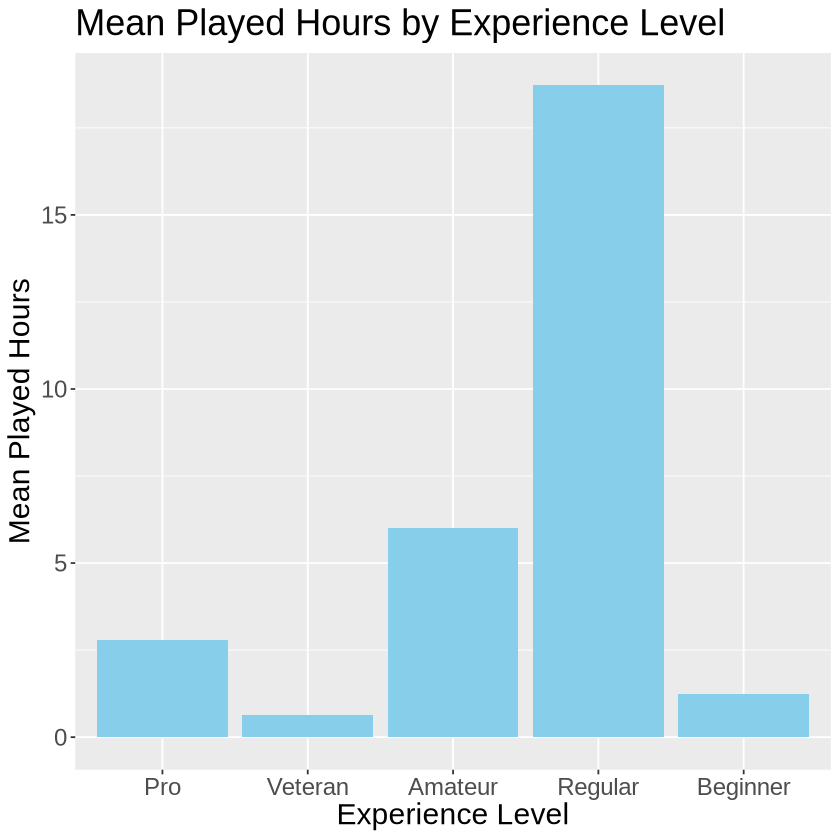

In [16]:
players_tidy |>
  group_by(experience) |>
  summarise(mean_played = mean(played_hours, na.rm = TRUE)) |>
  ggplot(aes(x = experience, y = mean_played)) +
  geom_col(fill = "skyblue") +
  labs(
    title = "Mean Played Hours by Experience Level",
    x = "Experience Level",
    y = "Mean Played Hours"
  )


Figure 4:
This bar graph shows that the highest amount of played hours come from Regulars, so they are the most likely to subsrcibe to a game related newsletter, due to their frequent Minecraft server engagement. On the contrary Beginners, and Veternas are the least likely to subscribe since they play the least, then Amatuers and Pro's are the second most likely to subscribe, since they play more than Veternas and Beginners, but less than Regulars. 

# 2. Methods and Results - K-Nearest Neighbors (K-NN) Classification

### Model Choice Justification
* K-NN directly supports a categorical response variable with known classes, in this case is **subscribe** (YES/NO).
* It works with both numeric and categorical predictors once scaling/encoding is applied.
* K-NN is part of the course teachings

### Assumptions required
* Distances between players must meaningfully reflect similarity after standardizing numeric predictors.
* Players who are “nearby” in feature space are assumed to have similar subscription behavior.

### Potential limitations or weaknesses
* Sensitive to variable scaling; numeric predictors must be standardized or they dominate the distance metric.
* Performance can decrease in effectiveness with too many predictors.
* Distance-based handling of categorical variables may not fully capture their meaning.

### Data processing / Analysis plan
After data was made tidy in section 1.3, this section will focus on the following:
* 2.1
    * Perform a 75% training / 25% testing split, grouped by **subscribe**.
    * Use only the training set for resampling, cross-validation, and model tuning
    * Use 5-fold CV on the training data and assess whether training data is balanced
    * Tune the number of neighbors K across 1 to 51
    * Select the K that gives the highest average cross-validated accuracy
    * Standardize numeric predictors (**age**, **played_hours**) using `step_scale()` and `step_center()`
* 2.2 - 2.3
    * Evaluate the final model once on the test set to estimate prediction accuracy
    * Visualize results of the tuned model on testing set
    * Re-evaluate model with manually tuned parameters if needed


### 2.1 Tuning the classifier

In [17]:
slice(players_tidy, 1:8) #for preview

subscribe,experience,played_hours,Age,gender
<fct>,<fct>,<dbl>,<dbl>,<fct>
TRUE,Pro,30.3,9,Male
TRUE,Veteran,3.8,17,Male
FALSE,Veteran,0.0,17,Male
TRUE,Amateur,0.7,21,Female
TRUE,Regular,0.1,21,Male
TRUE,Amateur,0.0,17,Female
TRUE,Regular,0.0,19,Female
FALSE,Amateur,0.0,21,Male


### 2.1.1 Train/Test Split of Players Dataset

In [18]:
set.seed(1234) # Setting the seed to make this data split reproducible
players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe) # 75% training / 25% testing split
players_train <- training(players_split)
players_test <- testing(players_split)

### 2.1.2 Creating a Recipe to Standardize Data With Training Split

In [19]:
players_recipe <- recipe(subscribe ~ ., data = (players_train)) |>
    step_dummy(experience, gender) |> #step_dummy was used to convert these factor variables into encodings to be predictors
    step_zv(all_predictors()) |>       #remove zero-variance columns
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#Assessing whether the training split is balanced
players_train_subscribe_counts <- players_train |>
  count(subscribe)
players_train_subscribe_counts

subscribe,n
<fct>,<int>
FALSE,39
TRUE,106


### 2.1.3 Creating the Classfier Using K-nearest Neighbours

In [20]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> #Optimal numbers of K-nearest neighbours initially using the tune() function.
            set_engine("kknn") |> #knn engine is used for K-nearest Neighbours classification for straight-line distance.
            set_mode("classification") #classification mode is desired.

k_vals <- tibble(neighbors = seq(from = 1, to = 51, by = 1))

### 2.1.4 Five-fold Cross Validation and Obtain Accuracies

In [21]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe) #Splitting training data into 5 folds for cross validation

In [22]:
players_fit_results <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(knn_tune) |>
             tune_grid(
                 resamples = players_vfold,
                 grid = k_vals) |>
             collect_metrics()

players_accuracies <- players_fit_results |>
  filter(.metric == "accuracy")

players_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5791297,5,0.020437816,Preprocessor1_Model01
2,accuracy,binary,0.5929228,5,0.013458748,Preprocessor1_Model02
3,accuracy,binary,0.5938752,5,0.034696398,Preprocessor1_Model03
4,accuracy,binary,0.6140887,5,0.026250011,Preprocessor1_Model04
5,accuracy,binary,0.6900000,5,0.031933343,Preprocessor1_Model05
6,accuracy,binary,0.6759606,5,0.025353144,Preprocessor1_Model06
7,accuracy,binary,0.7244992,5,0.023462645,Preprocessor1_Model07
8,accuracy,binary,0.7107061,5,0.031321700,Preprocessor1_Model08
9,accuracy,binary,0.7311494,5,0.012011907,Preprocessor1_Model09


### 2.1.5 Accuracy Across Neighborhood Sizes (K = 1 to 51)

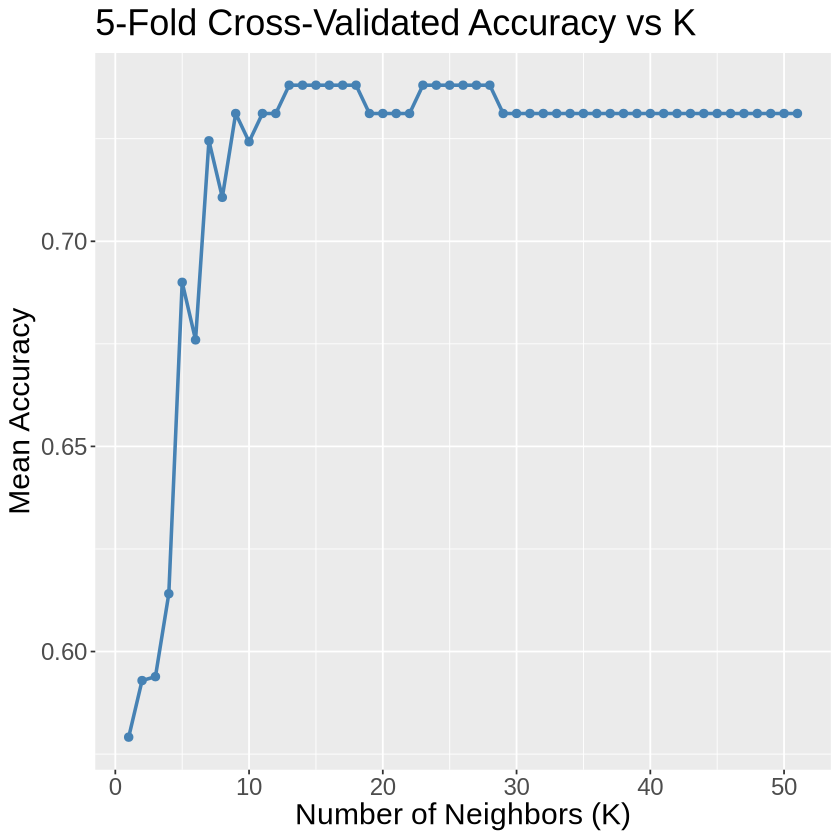

In [23]:
five_fold_accuracy_vs_k = players_accuracies |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line(color = "steelblue", linewidth = 1) +
  geom_point(color = "steelblue", size = 2) +
  labs(
    title = "5-Fold Cross-Validated Accuracy vs K",
    x = "Number of Neighbors (K)",
    y = "Mean Accuracy"
  )

five_fold_accuracy_vs_k

The graph above shows sharp increases in accuracy from k=1 to k=8, and then reaches it's peak around k=13 before leveling off. This means that the model's acuracy becomes better as k increases, but it's highest accuracy around k=13. After that, adding more nieghbors causes the accuracy to level off.

### 2.1.6 Selecting the Optimal K Value (Highest Accuracy, Smallest K)

In [24]:
best_k <- players_accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 13

### 2.2 Test Set Classification Results for the Tuned K-NN Model (K = 13)

### 2.2.1 K-NN Model Creation

In [25]:
knn_final <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors   = best_k
) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_final) |>
  fit(data = players_train)


### 2.2.2 Generate predictions on test dataset

In [35]:
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)


### 2.2.3 Final Evaluation (Test Set Evaluation)

In [40]:
players_test_metrics <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

players_test_accuracy <- players_test_metrics |>
  filter(.metric == "accuracy") |>
  pull(.estimate)

model_evaluation <- tibble(accuracy = players_test_accuracy,  precision = 35 / (35 + 13), recall_sensitivity = 35 / (35 + 1), specificity = 0) # numbers taken from confusion matrix below
model_evaluation

accuracy,precision,recall_sensitivity,specificity
<dbl>,<dbl>,<dbl>,<dbl>
0.7346939,0.7291667,0.9722222,0


### 2.2.4  Visualization of Evaluation

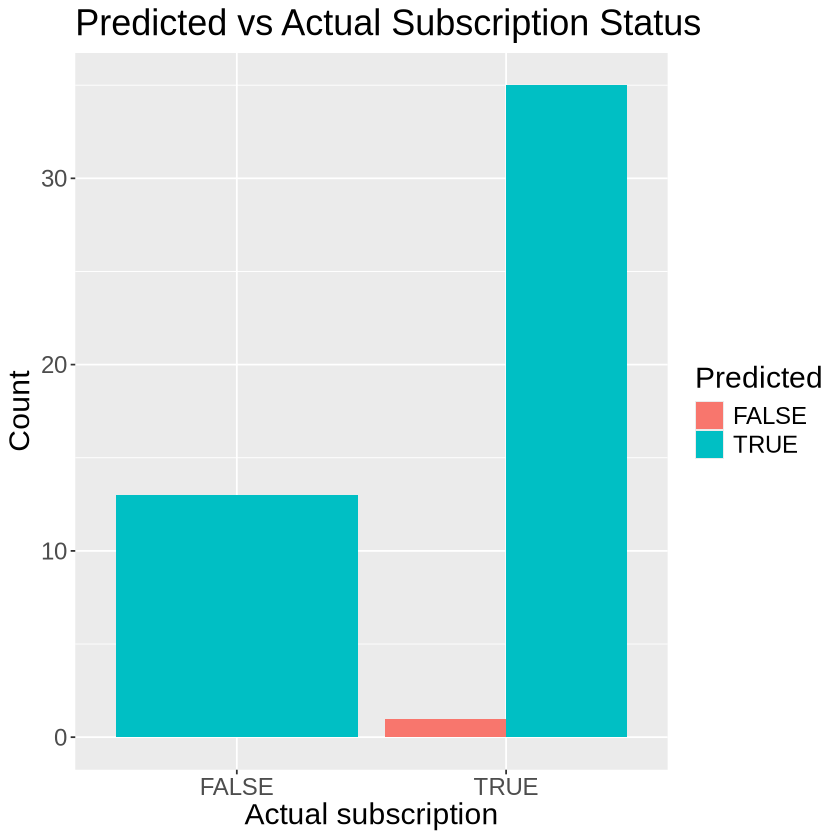

In [28]:
players_test_predictions |>
  count(subscribe, .pred_class) |>
  ggplot(aes(x = subscribe, y = n, fill = .pred_class)) +
  geom_col(position = "dodge") +
  labs(
    title = "Predicted vs Actual Subscription Status",
    x = "Actual subscription",
    y = "Count",
    fill = "Predicted"
  )

### 2.2.5  Confusion Matrix

In [29]:
players_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

Out of 13 actually FALSE cases, all 13 were predicted to be TRUE. Out of 36 actually TRUE cases, 35 were predicted correctly as TRUE. Meaning, the overall accuracy (71.43%) for this model appears high, but it is entirely driven by the model’s tendency to always predict the majority class (TRUE), supported by the 0 true FALS rate, specificity. As a result, the classifier achieves good accuracy simply by matching the dominant pattern in the dataset rather than learning meaningful distinctions between subscribers and non-subscribers.

### 2.3 Test Set Classification Results for a Non-Optimal K-NN Classifier (K = 5) and Model Evaluation

Although cross-validation optimized accuracy at K=13, the model failed to identify FALSE subscription cases (0 true negatives). To understand both subscribers and non-subscribers, this behavior is unacceptable. This is a sign of underfitting, therefore we chose a smaller K without compensating accuracy. We select a smaller K with accuracy close to the best accuracy K (refer to Graph 2.1.5). K=5 was chosen, and it is shown below to provide more balanced performance. 

accuracy,precison,recall_sensitivity,specificity
<dbl>,<dbl>,<dbl>,<dbl>
0.7346939,0.7804878,0.8888889,0.3076923


          Truth
Prediction FALSE TRUE
     FALSE     4    4
     TRUE      9   32

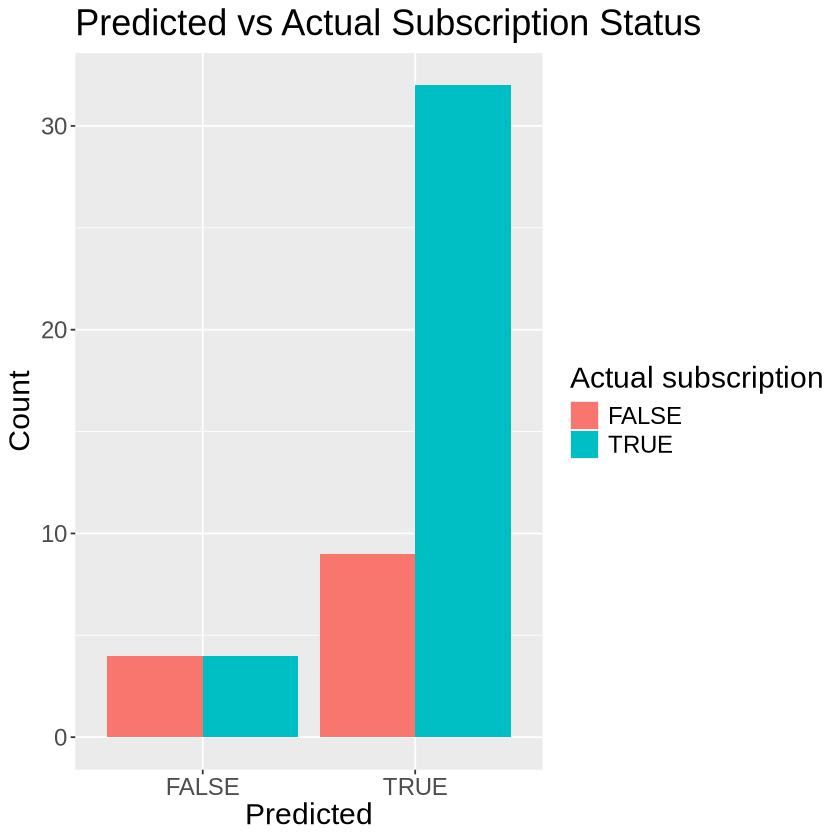

In [41]:
# Model Specification K=5
knn_final <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors   = 5
) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_final) |>
  fit(data = players_train)

# Generate Predictions
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

# Final Model Evaluation
players_test_metrics <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

players_test_accuracy <- players_test_metrics |>
  filter(.metric == "accuracy") |>
  pull(.estimate)

model_evaluation <- tibble(accuracy = players_test_accuracy, precison = 32/(32+9), recall_sensitivity = 32/(32+4), specificity = 4/(4+9)) # numbers taken from confusion matrix below
model_evaluation

# Results
players_test_predictions |>
  count(subscribe, .pred_class) |>
  ggplot(aes(x = .pred_class, y = n, fill = subscribe)) +
  geom_col(position = "dodge") +
  labs(
    title = "Predicted vs Actual Subscription Status",
    x = "Predicted",
    y = "Count",
    fill = "Actual subscription"
  )

players_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)


Out of 13 actually FALSE cases, the model correctly identified 4, while misclassifying 9 as TRUE. For the 36 actually TRUE cases, the model correctly predicted 32 and misclassified 4 as FALSE. This produces a model that is able to capture the majority subscription behavior reasonably well (accuracy 73.46%), while also showing a meaningful improvement in detecting non-subscribers compared to larger K values. As for precision, when the model predicts a player will subscribe, it is correct about 78.05% of the time. For recall, the model successfully identifies about 88.89% of players who actually subscribed. The specificity value suggests that the model correctly predicts 30.77% of players who do not subscribe as FALSE.

# 3. Discussion

### Overview
To evaluate the performance of the K-NN classifier and determine the optimal K for predicting newsletter subscriptions, models were tuned through 5-fold CV with their actual behavior on the test set. First, while CV identified K = 13 as the value with the highest estimated accuracy, our test-set evaluation revealed that this choice led to underfitting of the minority class (non-subscribers). Second, Because accuracy alone can be misleading for imbalanced datasets, especially when one class dominates, we examined additional evaluation metrics such as precision, recall, and specificity, as well as the confusion matrices for each candidate K value. This broader assessment provided a bettwe understanding of the model’s strengths and limitations.

### Justification for Selecting K = 5 Over CV Optimal K = 13
Although CV identified K = 13 as the value with the highest accuracy, we observed a strong underfitting effect, where the model predicted almost all players as subscribers, failing to identify non-subscribers (refer to specificity = 0 in section 2.2.3). This behavior aligns with the discussion in Section 6.6.3 of the textbook, where large values of K cause excessive smoothing and lead to underfitting. Because the accuracy curve was relatively flat across K (0.69 at K = 5 vs 0.738 at K = 13), choosing a smaller K provided a better balance between overfitting and underfitting. In particular, K = 5 produced a substantially more balanced confusion matrix and achieved a better accuracy.

### Results of KNN Classification and Model Evaluation Discussion 
We focus the final results on model with K = 5 (section 2.3). the classification had an accuracy of 73.47% which means that out of the 49 players on the testing split, the classifier correctly determined whether 36 players would subscribe to the Minecraft newsletter. By looking at the "Predicted vs Actual Subscription Status" plot, for true predictions it is observed that the classifier significantly classified more true positives (32) than false positives (9), which aligns with the bottom row of the confusion matrix. However, when looking at false predictions the classifier classified an equal number of true negatives (4) and false negatives (4), which aligns with the top row of the confusion matrix. This demonstrates that even after the number of K neighbours is set to 5, the classifier is not good at determining non-subscribers. Misclassifying a non-subscriber would not be a major problem since predicting whether a player will subscribe is more important from an economical perspective to target players. 

Additionally it is worth noting that the accuracy of 73.47% and a performance that is better at determining subscribers and bad at determining non-subscribers is likely due to training the model with an unbalanced dataset as the training split contained 106 people that subscribed and 39 people who did not. A precision of 78.05% for this classification means that out of all positive predictions the model made, 78% were correct, meaning the model is relatively reliable when it predicts that a player will subscribe. A recall of 88.89% indicates that the model successfully identified 89% of all true subscribers, meaning that the classifier is effective at detecting players who genuinely subscribe, which aligns well with answering ultimate question. However, the low specificity (30.77%) shows that the model still struggles to detect non-subscribers. Taken together, these metrics show that while the classifier is valuable for identifying likely subscribers, its ability to identify non-subscribers remains limited, and future improvements may require addressing dataset imbalance or adding more informative predictors.

To answer the original qestion, a player's experience, hours played, age and gender can predict whether a player would subscribe to a game-related newsletter based on this investigation's classification results and such as classification would be benificial to target players to subscribe from an enconomical stand point as there is a low risk in missclassification. However, a more balance dataset and choosing the best predictors in experience, hours played, age and gender would benifit future classification. 